# All Apple stores

Visualizing geographically all Apple stores in the U.S. Dataset from Apple Storefronts [applestorefronts.appspot.com](https://applestorefronts.appspot.com/).

In [1]:
import pandas as pd
import requests
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from bs4 import BeautifulSoup
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore') 

### 1. Web scrape

In [2]:
# scrape and collect the data on all the Apple stores
url = 'https://applestorefronts.appspot.com/'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'}
page = requests.get(url, headers=headers)

In [3]:
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('div', class_='container')[1]
store_elements = results.find_all('div', class_='store')

In [4]:
def create_df():
    rows = list()
    
    for store_element in store_elements:
        p_tags = store_element.find_all('p')

        store_text = p_tags[0].text
        store_id = store_text.split(' ', 1)[0].strip('#')
        store_name = store_text.split(' ', 1)[1].rsplit(' ', 1)[0]
        store_rnum = store_text.rsplit(' ', 1)[1]

        location = p_tags[1].text
        if ', ' not in location:
            city = country = location
        else:
            city = location.rsplit(', ', 1)[0]
            country = location.rsplit(', ', 1)[1]
        
        date_opened = p_tags[2].text.split('Opened:')[1].strip()

        row = [store_id, store_name, store_rnum, city, country, date_opened]
        rows.append(row)
        
    df = pd.DataFrame(rows, columns=cols)

    return df

### 2. Build the dataframe

In [5]:
cols = ['store_id', 'store_name', 'store_rnum', 'city', 'country', 'date_opened']

df_apple = create_df()
df_apple['date_opened'] = pd.to_datetime(df_apple['date_opened'])
df_apple = df_apple.set_index('date_opened')
df_apple

,store_id,store_name,store_rnum,city,country
date_opened,,,,,
2023-03-31,523,Gangnam,R691,Seoul,Korea
2022-12-03,522,American Dream,R755,"East Rutherford, NJ",USA
2022-09-24,521,Jamsil,R751,Seoul,Korea
2022-07-28,520,Brompton Road,R329,London,UK
2022-05-21,519,Wuhan,R575,Wuhan,China
...,...,...,...,...,...
2001-09-01,5,MarketStreet,R011,"Lynnfield, MA",USA
2001-08-23,4,Woodfield,R018,"Schaumburg, IL",USA
2001-08-11,3,Mall of America,R007,"Bloomington, MN",USA


In [6]:
# add `year` column to aggregate on
df_apple['year'] = df_apple.index.strftime('%Y')

In [7]:
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2023-03-31 to 2001-05-19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   store_id    523 non-null    object
 1   store_name  523 non-null    object
 2   store_rnum  523 non-null    object
 3   city        523 non-null    object
 4   country     523 non-null    object
 5   year        523 non-null    object
dtypes: object(6)
memory usage: 28.6+ KB


In [8]:
df_apple.sort_values(by='date_opened', ascending=False)

,store_id,store_name,store_rnum,city,country,year
date_opened,,,,,,
2023-03-31,523,Gangnam,R691,Seoul,Korea,2023
2022-12-03,522,American Dream,R755,"East Rutherford, NJ",USA,2022
2022-09-24,521,Jamsil,R751,Seoul,Korea,2022
2022-07-28,520,Brompton Road,R329,London,UK,2022
2022-05-21,519,Wuhan,R575,Wuhan,China,2022
...,...,...,...,...,...,...
2001-09-01,5,MarketStreet,R011,"Lynnfield, MA",USA,2001
2001-08-23,4,Woodfield,R018,"Schaumburg, IL",USA,2001
2001-08-11,3,Mall of America,R007,"Bloomington, MN",USA,2001


### 3. Visualize

Number of store locations by country:

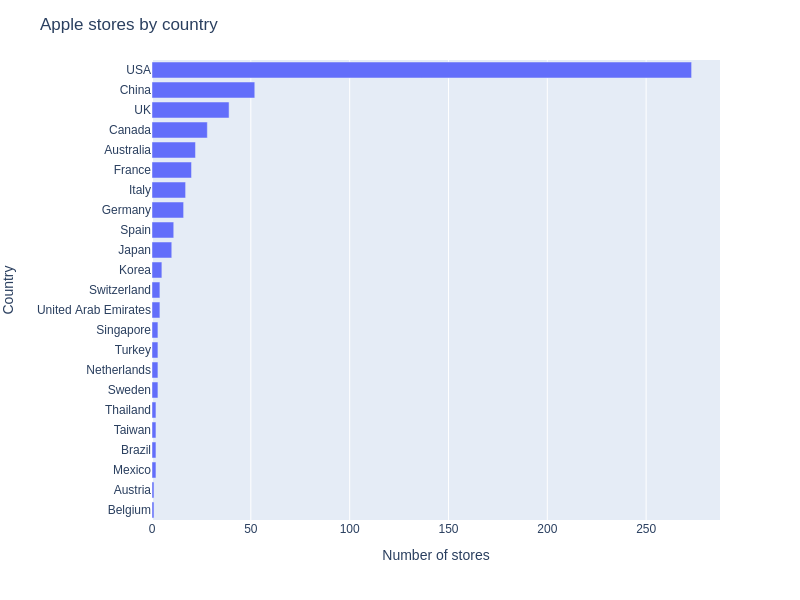

In [9]:
fig = px.bar(
    df_apple.country.value_counts().to_frame(name='count').reset_index()
    , x='count', y='index'
    , orientation='h'
    , labels={'index': 'Country', 'count': 'Number of stores'}
    , width=800, height=600
)
fig.update_layout(
    title_text='Apple stores by country'
    , yaxis=dict(autorange='reversed')
)
fig.show(renderer='png')

Number of store locations by year opened:

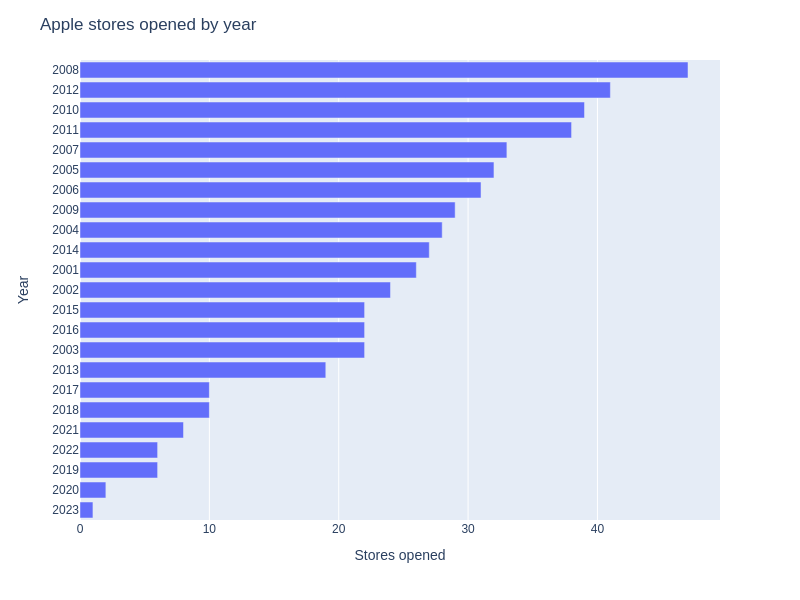

In [10]:
df_apple_by_year = df_apple.year.value_counts().to_frame(name='count').reset_index()

fig = px.bar(
    df_apple_by_year
    , x='count', y='index'
    , orientation='h'
    , labels={'index': 'Year', 'count': 'Stores opened'}
    , width=800, height=600
)
fig.update_layout(
    title_text='Apple stores opened by year'
    , yaxis=dict(autorange='reversed')
)
fig.show(renderer='png')

**Note: The first iPhone was released in the U.S. in June 2007**

In [11]:
# number of stores that opened in 2007 & 2008 alone
print('Number of stores that opened in 2007 & 2008 (worldwide):', len(df_apple.query('date_opened.dt.year in [2007, 2008]')))
print('Number of stores that opened in 2007 & 2008 (USA alone):', len(df_apple.query('date_opened.dt.year in [2007, 2008] and country=="USA"')))

Number of stores that opened in 2007 & 2008 (worldwide): 80
Number of stores that opened in 2007 & 2008 (USA alone): 55


In [12]:
# USA only stores
df_apple_usa = df_apple.query('country=="USA"')
df_apple_usa

,store_id,store_name,store_rnum,city,country,year
date_opened,,,,,,
2022-12-03,522,American Dream,R755,"East Rutherford, NJ",USA,2022
2021-09-24,514,The Mall at Bay Plaza,R753,"Bronx, NY",USA,2021
2021-06-24,512,Tower Theatre,R720,"Los Angeles, CA",USA,2021
2021-03-29,510,Downtown Nashville,R133,"Nashville, TN",USA,2021
2019-05-11,501,Carnegie Library,R516,"Washington, DC",USA,2019
...,...,...,...,...,...,...
2001-09-01,5,MarketStreet,R011,"Lynnfield, MA",USA,2001
2001-08-23,4,Woodfield,R018,"Schaumburg, IL",USA,2001
2001-08-11,3,Mall of America,R007,"Bloomington, MN",USA,2001


Add lat/lng coordinates:

In [13]:
# cities db with lat/long coords
df_usa_cities = pd.read_csv('data/uscities.csv', usecols=['city', 'state_id', 'lat', 'lng'])

df_usa_cities.head()

,city,state_id,lat,lng
0,New York,NY,40.6943,-73.9249
1,Los Angeles,CA,34.1141,-118.4068
2,Chicago,IL,41.8375,-87.6866
3,Miami,FL,25.7840,-80.2101
4,Dallas,TX,32.7935,-96.7667


In [14]:
# add new column to match against
df_usa_cities['city_state'] = df_usa_cities['city'] + ', ' + df_usa_cities['state_id']
df_usa_cities

,city,state_id,lat,lng,city_state
0,New York,NY,40.6943,-73.9249,"New York, NY"
1,Los Angeles,CA,34.1141,-118.4068,"Los Angeles, CA"
2,Chicago,IL,41.8375,-87.6866,"Chicago, IL"
3,Miami,FL,25.7840,-80.2101,"Miami, FL"
4,Dallas,TX,32.7935,-96.7667,"Dallas, TX"
...,...,...,...,...,...
30839,Ironville,PA,40.6586,-78.2155,"Ironville, PA"
30840,Newkirk,NM,35.0635,-104.2715,"Newkirk, NM"
30841,Falcon Village,TX,26.5652,-99.1341,"Falcon Village, TX"
30842,Hidden Lakes,OH,40.5479,-82.7632,"Hidden Lakes, OH"


Store location cities not in the db or didn't match against:

In [15]:
set(df_apple_usa.city.tolist()).difference(df_usa_cities.city_state.tolist())

{'Braintree, MA',
 'Bridgewater, NJ',
 'Burlington, MA',
 'Canoga Park, CA',
 'Century City, CA',
 'Cherry Hill, NJ',
 'Chestnut Hill, MA',
 'Dedham, MA',
 'Edison, NJ',
 'Farmington, CT',
 'Freehold, NJ',
 'Greenwich, CT',
 'Hingham, MA',
 'Lawrence Township, NJ',
 'Lynnfield, MA',
 'Natick, MA',
 'Northridge, CA',
 'Rockaway, NJ',
 'S. Portland, ME',
 'Salem, NH',
 'Sherman Oaks, CA',
 'South Windsor, CT',
 'Trumbull, CT',
 'Valencia, CA',
 'Victor, NY',
 'Wayne, NJ',
 'Whitehall, PA'}

Merge:

In [16]:
df_apple_usa = df_apple_usa.merge(df_usa_cities.drop(columns=['city', 'state_id']), left_on='city', right_on='city_state', how='left').drop(columns='city_state')
df_apple_usa

,store_id,store_name,store_rnum,city,country,year,lat,lng
0,522,American Dream,R755,"East Rutherford, NJ",USA,2022,40.8179,-74.0854
1,514,The Mall at Bay Plaza,R753,"Bronx, NY",USA,2021,40.8501,-73.8662
2,512,Tower Theatre,R720,"Los Angeles, CA",USA,2021,34.1141,-118.4068
3,510,Downtown Nashville,R133,"Nashville, TN",USA,2021,36.1715,-86.7842
4,501,Carnegie Library,R516,"Washington, DC",USA,2019,38.9047,-77.0163
...,...,...,...,...,...,...,...,...
268,5,MarketStreet,R011,"Lynnfield, MA",USA,2001,NaN,NaN
269,4,Woodfield,R018,"Schaumburg, IL",USA,2001,42.0308,-88.0838
270,3,Mall of America,R007,"Bloomington, MN",USA,2001,44.8306,-93.3151
271,2,Glendale Galleria,R001,"Glendale, CA",USA,2001,34.1819,-118.2468


Cities with missing coordinates:

In [17]:
df_apple_usa[df_apple_usa.lat.isna() | df_apple_usa.lng.isna()]

,store_id,store_name,store_rnum,city,country,year,lat,lng
18,429,Trumbull,R629,"Trumbull, CT",USA,2014,NaN,NaN
22,423,Evergreen Walk,R613,"South Windsor, CT",USA,2014,NaN,NaN
27,397,Quaker Bridge,R549,"Lawrence Township, NJ",USA,2013,NaN,NaN
43,317,Valencia Town Center,R462,"Valencia, CA",USA,2011,NaN,NaN
58,271,Greenwich Avenue,R282,"Greenwich, CT",USA,2009,NaN,NaN
64,256,Legacy Place,R346,"Dedham, MA",USA,2009,NaN,NaN
79,227,Willowbrook,R325,"Wayne, NJ",USA,2008,NaN,NaN
80,225,Maine Mall,R307,"S. Portland, ME",USA,2008,NaN,NaN
97,200,Cherry Hill,R206,"Cherry Hill, NJ",USA,2008,NaN,NaN
104,189,Lehigh Valley,R281,"Whitehall, PA",USA,2007,NaN,NaN


Adding missing coordinates manually:

In [18]:
# cities with lat/long coords
df_usa_cities_missing = pd.read_csv('data/missing_lat_lng.csv')

df_usa_cities_missing.head()

,city_state,lat,lng
0,"Braintree, MA",42.205991,-71.004983
1,"Bridgewater, NJ",40.594948,-74.630928
2,"Burlington, MA",42.505990,-71.194077
3,"Canoga Park, CA",34.201019,-118.605927
4,"Century City, CA",34.208326,-118.605961


In [19]:
for city in (df_apple_usa[df_apple_usa.lat.isna() | df_apple_usa.lng.isna()].city.tolist()):
    idx_1 = df_apple_usa[df_apple_usa['city'] == city].index.item()
    idx_2 = df_usa_cities_missing[df_usa_cities_missing['city_state'] == city].index.item()
    df_apple_usa.loc[[idx_1], ['lat','lng']] = df_usa_cities_missing.loc[[idx_2], ['lat','lng']].values.tolist()

Confirming all locations have their coordinates:

In [20]:
df_apple_usa[df_apple_usa.lat.isna() | df_apple_usa.lng.isna()]

,store_id,store_name,store_rnum,city,country,year,lat,lng


In [21]:
df_apple_usa

,store_id,store_name,store_rnum,city,country,year,lat,lng
0,522,American Dream,R755,"East Rutherford, NJ",USA,2022,40.817900,-74.085400
1,514,The Mall at Bay Plaza,R753,"Bronx, NY",USA,2021,40.850100,-73.866200
2,512,Tower Theatre,R720,"Los Angeles, CA",USA,2021,34.114100,-118.406800
3,510,Downtown Nashville,R133,"Nashville, TN",USA,2021,36.171500,-86.784200
4,501,Carnegie Library,R516,"Washington, DC",USA,2019,38.904700,-77.016300
...,...,...,...,...,...,...,...,...
268,5,MarketStreet,R011,"Lynnfield, MA",USA,2001,42.538817,-71.047276
269,4,Woodfield,R018,"Schaumburg, IL",USA,2001,42.030800,-88.083800
270,3,Mall of America,R007,"Bloomington, MN",USA,2001,44.830600,-93.315100
271,2,Glendale Galleria,R001,"Glendale, CA",USA,2001,34.181900,-118.246800


Apple store locations, by year opened:

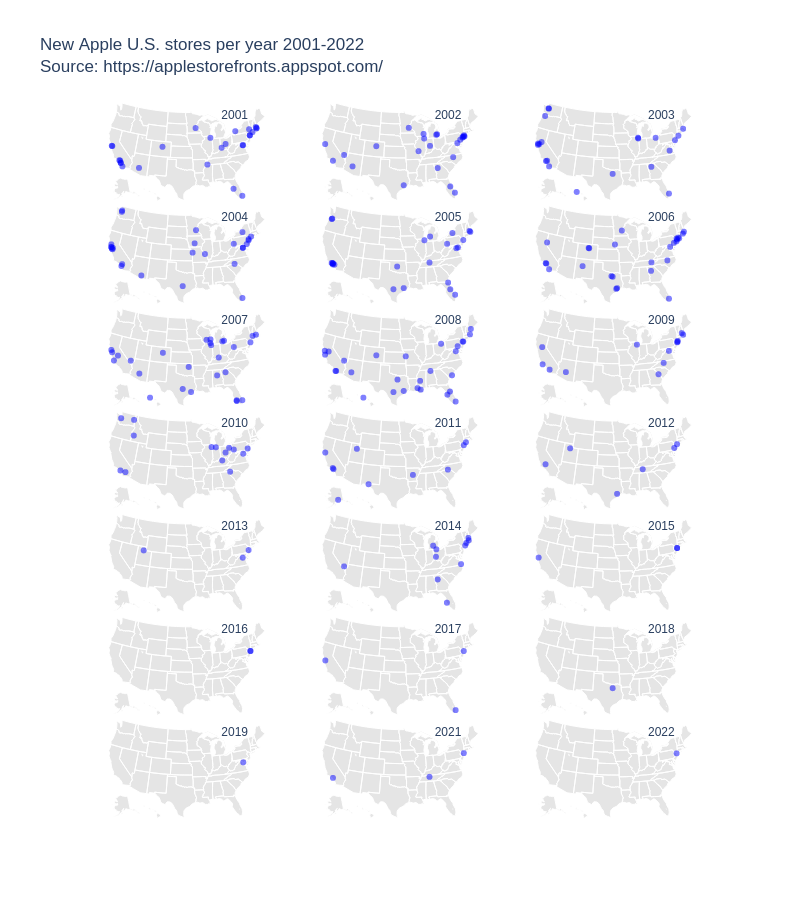

In [22]:
data = []
layout = dict(
    title = 'New Apple U.S. stores per year 2001-2022<br>\
Source: <a href="https://applestorefronts.appspot.com/">\
https://applestorefronts.appspot.com/</a>',
    # showlegend = False,
    autosize = False,
    width = 1000,
    height = 900,
    hovermode = False,
    legend = dict(
        x=0.7,
        y=-0.1,
        bgcolor="rgba(255, 255, 255, 0)",
        font = dict( size=11 ),
    )
)
years = df_apple_usa['year'].unique()[::-1]

for i in range(len(years)):
    geo_key = 'geo'+str(i+1) if i != 0 else 'geo'
    lons = list(df_apple_usa[ df_apple_usa['year'] == years[i] ]['lng'])
    lats = list(df_apple_usa[ df_apple_usa['year'] == years[i] ]['lat'])
    # Apple store data
    data.append(
        dict(
            type = 'scattergeo',
            showlegend=False,
            lon = lons,
            lat = lats,
            geo = geo_key,
            name = int(years[i]),
            marker = dict(
                color = "rgb(0, 0, 255)",
                opacity = 0.5
            )
        )
    )
    # Year markers
    data.append(
        dict(
            type = 'scattergeo',
            showlegend = False,
            lon = [-78],
            lat = [47],
            geo = geo_key,
            text = [years[i]],
            mode = 'text',
        )
    )
    layout[geo_key] = dict(
        scope = 'usa',
        showland = True,
        landcolor = 'rgb(229, 229, 229)',
        showcountries = False,
        domain = dict( x = [], y = [] ),
        subunitcolor = "rgb(255, 255, 255)",
    )

z = 0
COLS = 3
ROWS = 7
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(z+1) if z != 0 else 'geo'
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1
        if z > 20:
            break

fig = go.Figure(data=data, layout=layout)
fig.update_layout(width=800)
fig.show(renderer='png')

All Apple store locations currently (2023):

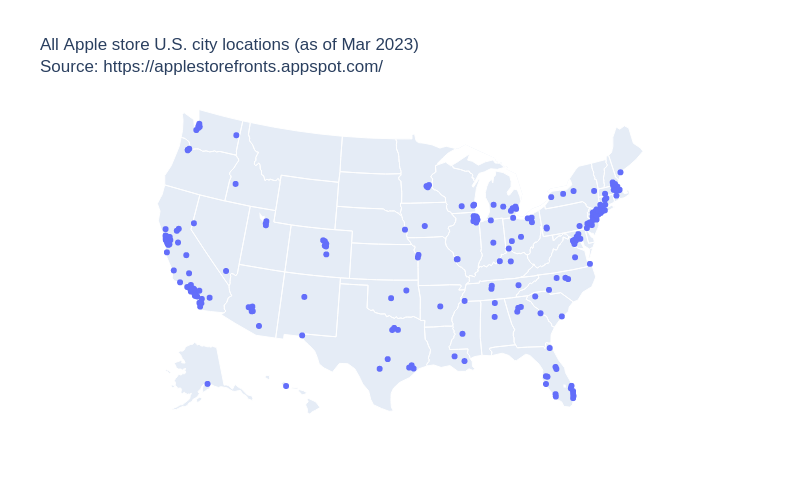

In [23]:
df_apple_usa_by_unique_city = df_apple_usa.groupby(['city', 'lat', 'lng']).agg('count').reset_index()

fig = go.Figure(data=go.Scattergeo(
    lon = df_apple_usa_by_unique_city['lng'],
    lat = df_apple_usa_by_unique_city['lat'],
    hovertext = df_apple_usa_by_unique_city['city']
))

fig.update_layout(
    title = 'All Apple store U.S. city locations (as of Mar 2023)<br>\
Source: <a href="https://applestorefronts.appspot.com/">\
https://applestorefronts.appspot.com/</a>',
    geo_scope='usa',
)

fig.update_layout(width=800)
fig.show(renderer='png')